In [3]:
import os
import gc
import parse
import logging
import numpy as np
import pandas as pd
from utils import get_N_tokens, read_and_split_file, raw_dir, interim_dir, final_dir, load_SET_dataset, LABELS, load_rss_dataset

logging.basicConfig(format="%(asctime)s - %(message)s", level=logging.INFO)

# Reading the training dataset (WebCrawl):

In [4]:
texts, labels = list(), list()

files = ["bswac_tail_pp", "cnrwac_tail_pp_corrected_2", "hrwac_tail_pp", "srwac_tail_pp"]

langs = ["bs", "me", "hr", "sr"]

for file, lang in zip(files, langs):
    full_path = os.path.join(interim_dir, file)
    current_texts = read_and_split_file(full_path)
    len_cur_texts = len(current_texts)
    texts.extend(current_texts)
    labels.extend([lang] * len_cur_texts)

train = pd.DataFrame(data={"text": texts, "labels": labels})

# Loading the eval df:

In [5]:
eval_df = load_rss_dataset()

# Defining the eval functions and clf:

In [6]:
from sklearn.svm import LinearSVC
clf_lin_svc = LinearSVC(dual=False)

def get_stats(N: int, train=train, eval_df=eval_df, clf=clf_lin_svc, labels=LABELS):
    import gc
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.metrics import (
        f1_score,
        ConfusionMatrixDisplay,
        confusion_matrix,
        accuracy_score,
    )

    gc.collect()
    vocabulary = get_N_tokens(N)

    def get_coverage(s:str) -> int:
        """Calculates how many vocabulary tokens are in the string.

        Args:
            s (str): input string

        Returns:
            int: number of DISTINCT vocabulary tokens in input string.
        """        
        word_set = set(s.split(" "))
        return len(word_set.intersection(vocabulary))
    vectorizer = CountVectorizer(vocabulary=vocabulary, lowercase=True, binary=True)
    
    eval_df["coverage"] = eval_df.text.apply(get_coverage)
    average_coverage = eval_df.coverage.mean()


    train_vectors = vectorizer.fit_transform(train.text)
    train_labels = train.labels
    test_vectors = vectorizer.fit_transform(eval_df.text)
    y_true = eval_df.labels


    clf.fit(train_vectors.toarray(), train_labels)
    y_pred = clf.predict(test_vectors.toarray())
    LABELS = labels
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS, average="micro")
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    bool_coverage = eval_df.coverage.value_counts()[0]
    returndict = {"N": N, "microF1": micro, "macroF1": macro, "accuracy": acc, "cm": cm,
    "coverage": average_coverage, "clf": clf.__str__(), "bool_coverage": bool_coverage,
    "bool_coverage_ratio": bool_coverage/len(y_true)}
    for lang in LABELS:
        idx = eval_df.labels == lang
        M = idx.sum()
        returndict[f"bool_coverage_ratio_{lang}"] = eval_df.loc[idx, "coverage"].value_counts().get(0, 0) / M
    return returndict

# Defining the clf and running the eval loop:

In [7]:
Ns = np.logspace(1, 4, 20, dtype=np.int)
results = list()
for N in Ns:
    try:
        logging.info(f"{N=}")
        rezdict = get_stats(N, train=train, eval_df=eval_df, clf=clf_lin_svc, labels=LABELS)
        rezdict["eval_df"] = "RSS"
        results.append(rezdict)
    except MemoryError:
        break

2022-01-25 10:23:41,579 - N=10
2022-01-25 10:23:43,291 - NumExpr defaulting to 8 threads.
2022-01-25 10:24:36,592 - N=14
2022-01-25 10:25:32,517 - N=20
2022-01-25 10:26:29,268 - N=29
2022-01-25 10:27:28,423 - N=42
2022-01-25 10:28:27,949 - N=61
2022-01-25 10:29:29,947 - N=88
2022-01-25 10:30:31,885 - N=127
2022-01-25 10:31:38,817 - N=183
2022-01-25 10:32:45,843 - N=263
2022-01-25 10:33:59,807 - N=379
2022-01-25 10:35:17,291 - N=545
2022-01-25 10:36:41,002 - N=784
2022-01-25 10:38:09,343 - N=1128
2022-01-25 10:39:45,260 - N=1623
2022-01-25 10:41:32,070 - N=2335
2022-01-25 10:43:35,562 - N=3359
2022-01-25 10:46:09,241 - N=4832
2022-01-25 10:49:10,328 - N=6951
2022-01-25 10:54:12,575 - N=10000


In [8]:
rezdf = pd.DataFrame(data=results)
rezdf.index = rezdf.N
rezdf = rezdf.drop(columns=["N"])
rezdf = rezdf.sort_index()
rezdf.to_csv("22_results_LinSVC_on_RSS_crawl.csv")


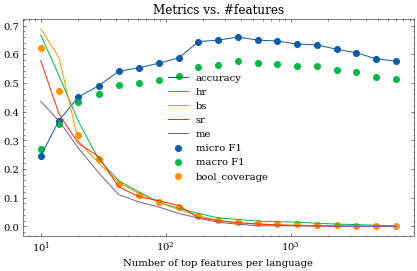

In [9]:
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

plt.figure(figsize=(7, 4))
plt.scatter(rezdf.index, rezdf["microF1"],label="micro F1")

plt.scatter(rezdf.index, rezdf["macroF1"],label="macro F1")

plt.plot(rezdf.index, rezdf["accuracy"],label="accuracy")
plt.scatter(rezdf.index, rezdf["bool_coverage_ratio"],label="bool_coverage")
plt.xlabel("Number of top features per language")

for lang in LABELS:
    plt.plot(rezdf.index, rezdf[f"bool_coverage_ratio_{lang}"], label=f"{lang}")
plt.legend()
plt.title("Metrics vs. #features")
plt.semilogx()
plt.savefig("images/22_LinSVC_on_RSS.png")
plt.show()